In [1]:
import pandas as pd
import json
import csv
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import networkx as nx
import json
from neo4j import GraphDatabase

## Connect to Reactome graph database using neo4j driver

In [25]:


class Neo4jConnection:
    def __init__(self, uri, user, password):
        self.__uri = uri
        self.__user = user
        self.__password = password
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__password))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()


            
    def query(self, query, parameters=None, db=None):
        with self.__driver.session(database=db) as session:
            result = list(session.run(query, parameters))
            # return [record for record in result]
            return result




In [49]:

def flatten_node_data(records):
    """Extracts and flattens data from Neo4j records into a list of dictionaries."""
    data = []
    for record in records:
        node = record['n']
        flat_data = dict(node)
        flat_data['element_id'] = node.id
        data.append(flat_data)
    return data

def save_to_csv(records, csv_file_path=None):
    """
    Converts Neo4j query results to a pandas DataFrame and optionally saves to a CSV file.
    
    :param records: List of Neo4j Record objects.
    :param csv_file_path: Optional path to save the CSV file. If None, no CSV will be saved.
    :return: pandas DataFrame containing the extracted data.
    """
    data = flatten_node_data(records)
    df = pd.DataFrame(data)
    
    if csv_file_path:
        df.to_csv(csv_file_path, index=False)
    
    return df


def save_to_gml_v2(query_output, file_name):

    G = nx.MultiDiGraph()


    node_id_map = {}


    for node, relationship in query_output.items():
        node_properties = dict(node._properties) 
        node_properties['labels'] = list(node.labels)  
        G.add_node(node.element_id, **node_properties)
        node_id_map[node.element_id] = node 

    for node, relationship in query_output.items():
        for rel_node in relationship.nodes:
            if rel_node.element_id != node.element_id:
                edge_properties = dict(relationship._properties)
                G.add_edge(node.element_id, rel_node.element_id, **edge_properties)

    nx.write_gml(G, file_name)


def convert_attributes(data):
    converted = {}
    for key, value in data.items():
        # Convert lists and dictionaries (and any other non-supported types) to strings
        if isinstance(value, (list, dict)):
            converted_value = json.dumps(value)
        else:
            converted_value = value
        converted[key] = converted_value
    return converted

def save_to_gml(query_results, file_name):

    G = nx.MultiDiGraph()
    
    for record in results:
        print(record._Record__keys[0])
        for node in record["nodes"]:
            node_attrs = dict(node)
            node_attrs_converted = convert_attributes(node_attrs)
            G.add_node(node.id, **node_attrs_converted)
            
        for relationship in record["relationships"]:
            rel_attrs = dict(relationship)
            rel_attrs_converted = convert_attributes(rel_attrs)
            G.add_edge(relationship.start_node.id, relationship.end_node.id, **rel_attrs_converted)
    
    nx.write_gml(G, file_name)

def save_to_gml_v3(query_results, file_name):
    G = nx.MultiDiGraph()
    for record in query_results:
        r = record[record._Record__keys[0]]
        rel = record[record._Record__keys[1]]
        connectedNodes = record[record._Record__keys[2]]

        # Add nodes
        G.add_node(r.id, label='Reaction', **dict(r))
        G.add_node(connectedNodes.id, **dict(connectedNodes))

        # Add edge
        G.add_edge(r.id, connectedNodes.id, key=rel.type, **dict(rel))

    # Save to GML
    nx.write_gml(G, file_name)
    print(f"Graph saved to {file_name}.")

## Query from reactome

#### Extract the nodes and edges that have species schemaClass Reaction and speciesName Mouse connect to 
```
MATCH (r:Reaction)-[rel]-(connectedNodes)
WHERE r.schemaClass = 'Reaction' AND r.speciesName = 'Mus musculus'
RETURN r, rel, connectedNodes 
```

#### Returns a collection of records, where each record represents a path involving "Mus musculus". Each record contains a list of nodes (nodes) that are part of the path and a list of relationships that connect the nodes in the path
```
MATCH path=(n)-[r:species]->(m) WHERE 'Mus musculus' IN n.speciesName OR 'Mus musculus' IN m.speciesName
WITH path, relationships(path) AS rs
RETURN nodes(path) AS nodes, rs AS relationships
```

#### Taxon??
```
MATCH (o)-[r:species]->(m:Taxon{abbreviation:'MMU'})
RETURN o AS nodes, r AS relationships
UNION
MATCH (o)-[s]-(n)-[r:species]->(m:Taxon{abbreviation:'MMU'})
WHERE type(s) <> 'created'
AND type(s) <> "reference_Database"
RETURN o AS nodes, r AS relationships


In [50]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "neo4j"

# First query

# query = """
# MATCH path=(n)-[r:species]->(m) WHERE 'Mus musculus' IN n.speciesName OR 'Mus musculus' IN m.speciesName
# WITH path, relationships(path) AS rs
# RETURN nodes(path) AS nodes, rs AS relationships """

# Second query

# query="""
# MATCH (o)-[r:species]->(m:Taxon{abbreviation:'MMU'})
# RETURN o AS nodes, r AS relationships
# UNION
# MATCH (o)-[s]-(n)-[r:species]->(m:Taxon{abbreviation:'MMU'})
# WHERE type(s) <> 'created'
# AND type(s) <> "reference_Database"
# RETURN o AS nodes, r AS relationships

# """

# Third query

# query="""
# MATCH (n)-[r:species]->(m:Taxon{abbreviation:'MMU'})
# RETURN n as nodes, r as relationships
# """

query= """
MATCH (r:Reaction)-[rel]-(connectedNodes)
WHERE r.schemaClass = 'Reaction' AND r.speciesName = 'Mus musculus'
RETURN r, rel, connectedNodes
limit 10
"""

# Establish connection
conn = Neo4jConnection(uri, user, password)
results = conn.query(query)
# results = dict(results)
save_to_gml_v3(results,'data/mouse_query_small_graph.gml')

# Close the connection
conn.close()

Graph saved to data/mouse_query_small_graph.gml.


/tmp/ipykernel_18803/910133039.py:88: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(r.id, label='Reaction', **dict(r))
/tmp/ipykernel_18803/910133039.py:89: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(connectedNodes.id, **dict(connectedNodes))
/tmp/ipykernel_18803/910133039.py:92: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_edge(r.id, connectedNodes.id, key=rel.type, **dict(rel))


## Read the gml file

In [51]:
G = nx.read_gml('data/mouse_query_small_graph.gml')

# Print the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 11
Number of edges: 10


## Visualize the graph

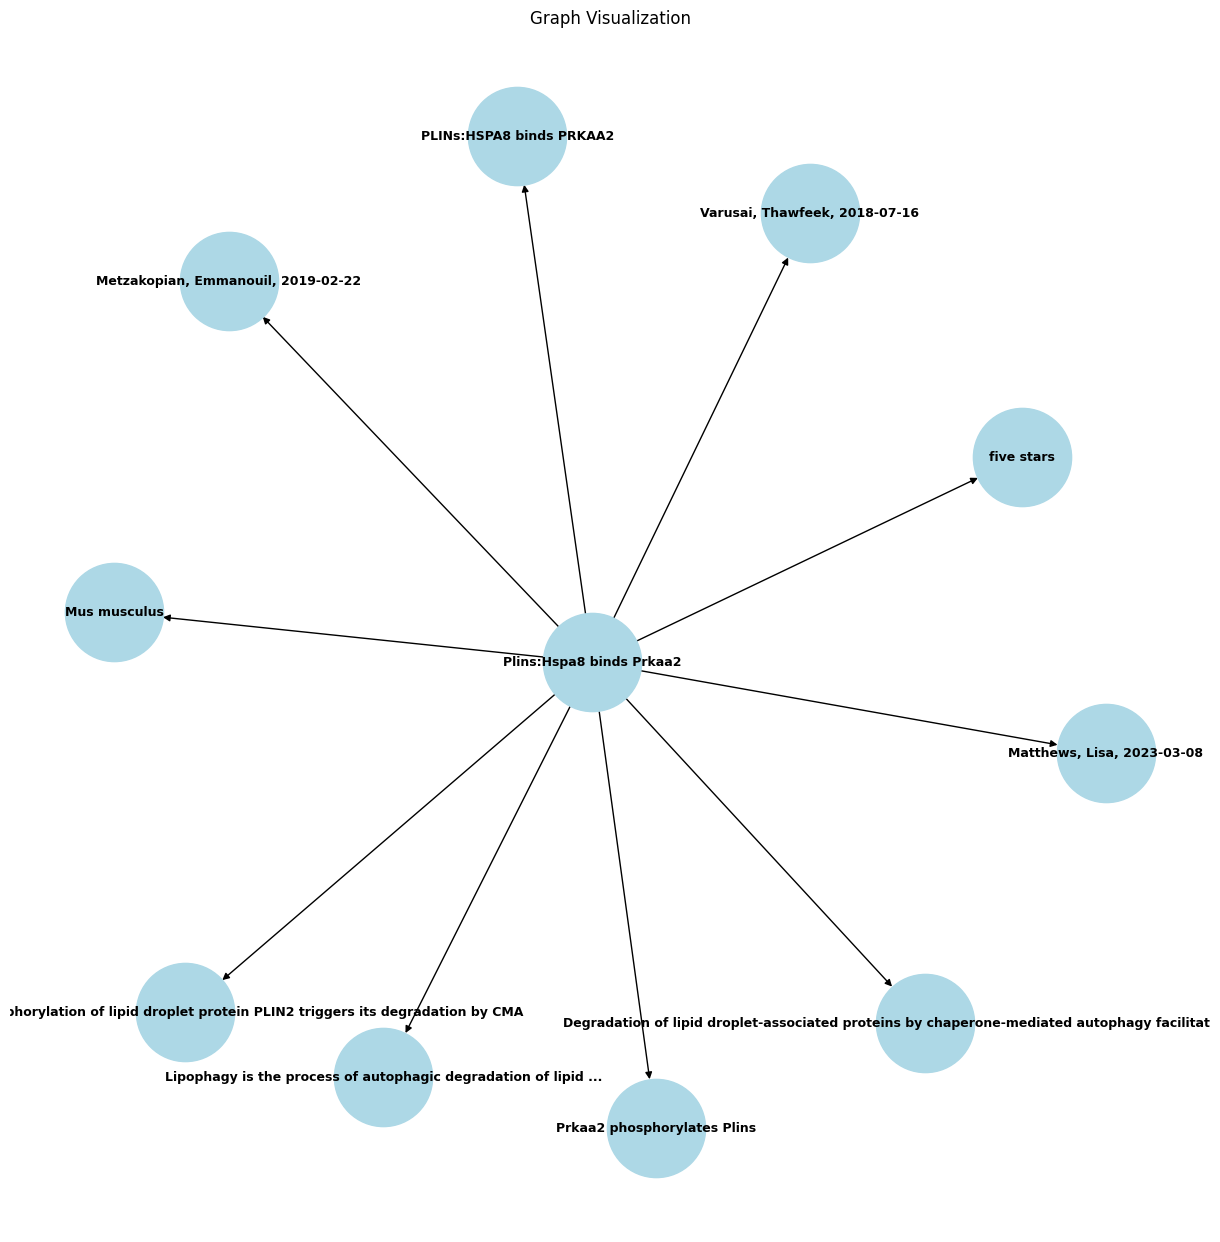

In [63]:
node_labels = {node: data['displayName'] for node, data in G.nodes(data=True)}

plt.figure(figsize=(12, 12)) 
nx.draw(G, with_labels=True, labels=node_labels, node_size=5000, node_color="lightblue", font_size=9, font_weight="bold")
plt.title("Graph Visualization")
plt.show()

## Save the nodes and the edges of the graph in csv files

In [56]:
nodes_data = list(G.nodes(data=True))  # List of tuples (node_id, attr_dict)
nodes_df = pd.DataFrame([{'node': n, **attr} for n, attr in nodes_data])
nodes_df.to_csv('nodes.csv', index=False)

# Edges
edges_data = list(G.edges(data=True))  # List of tuples (source, target, attr_dict)
edges_df = pd.DataFrame([{'source': s, 'target': t, **attr} for s, t, attr in edges_data])
edges_df.to_csv('edges.csv', index=False)

/tmp/ipykernel_34818/4275049995.py:22: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_node(node.id, **node_attrs_converted)
/tmp/ipykernel_34818/4275049995.py:28: DeprecationWarning: `id` is deprecated, use `element_id` instead
  G.add_edge(relationship.start_node.id, relationship.end_node.id, **rel_attrs_converted)
